In [1]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt

from gp_oed_surrogate import create_gp

In [2]:
# Plot settings:
mpl.rcParams['figure.dpi'] = 200

In [3]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

In [4]:
# Peak function (see: https://mathworks.com/help/matlab/ref/peaks.html)
def f(x, y):
    first_term = 3*(1-x)**2*jnp.exp(-x**2-(y+1)**2)
    second_term = -10*(x/5 - x**3 - y**5)*jnp.exp(-x**2-y**2)
    third_term = -1/3*jnp.exp(-(x+1)**2-y**2)
    return first_term + second_term + third_term

In [79]:
def plot_function(x, y, z, grid_shape, z_lims=None, train_pts=None, num_levels=1000):
    
    if z_lims is None:
        z_lims = (jnp.min(z), jnp.max(z), num_levels)
    levels = jnp.linspace(z_lims[0], z_lims[1], num_levels)
    
    # Reshape inputs:
    x, y, z = x.reshape(grid_shape), y.reshape(grid_shape), z.reshape(grid_shape)
    
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(x, y, z, levels=levels, cmap='coolwarm')
    fig.colorbar(contour_fig)
    if train_pts is not None:
        plt.plot(train_pts['x'], train_pts['y'], 'x', color='black', markersize=5)
    fig.patch.set_facecolor('white')
    plt.show()

In [80]:
def create_pointgrid(x_lims, y_lims, x_pts, y_pts, true_f=None):
    
    # Create list of points:
    x_pts = jnp.linspace(x_lims[0], x_lims[1], x_pts)
    y_pts = jnp.linspace(y_lims[0], y_lims[1], y_pts)
    # Create grid of points:
    y_grid, x_grid = jnp.meshgrid(x_pts, y_pts)
    # Store input:
    
    pts = {'x': x_grid.flatten(), 
           'y': y_grid.flatten(), 
           'input': jnp.stack([x_grid.flatten(), y_grid.flatten()], axis=1)}
    
    # Return z values if requested:
    if true_f is not None:
        pts['z'] = true_f(pts['x'], pts['y'])
    return pts 

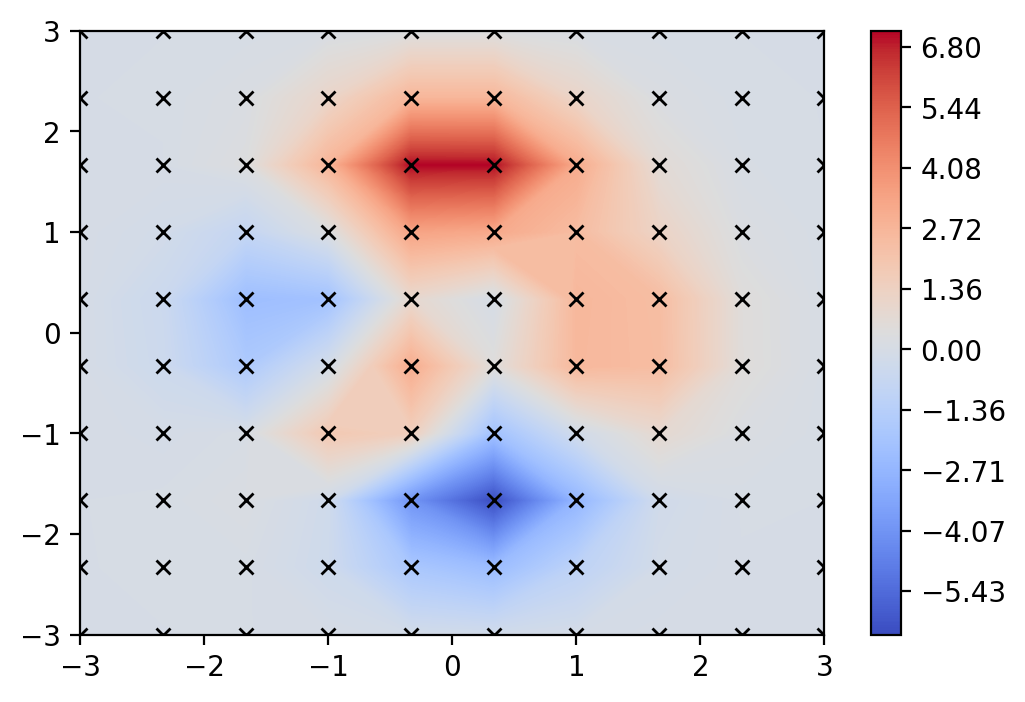

In [83]:
x_lims = y_lims = [-3, 3]
x_pts = y_pts = 10
f_vmap = jax.vmap(f, in_axes=[0,0])
trains_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts, true_f=f_vmap)
grid_shape = (y_pts, x_pts)

# Plot training data:
plot_function(trains_pts['x'], trains_pts['y'], trains_pts['z'], grid_shape, train_pts=trains_pts)

# Train GP

In [8]:
# Define constraints:
constraints = {"length_0": {">": 10**-1, "<": 10**1}, 
               "length_1": {">": 10**-1, "<": 10**1}, 
               "const": {">": 10**-1, "<": 10**2}}
# Create GP surrogate:
gp = create_gp(kernel, trains_pts['input'], trains_pts['z'], constraints)

157768.95
142336.2
130156.52
121820.99
128893.086
130579.99
183683.95
144618.23
121820.99
121820.99
121820.99
121820.99
121820.99
121820.99
121820.99
121820.99
121820.99
121820.99
121820.99
      fun: array(121820.9921875)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -335.05709839, 17627.81640625, 33101.30078125])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 4
     njev: 19
   status: 0
  success: True
        x: array([100.        ,   9.43705311,   1.26547221])
94871.836
322.27716
322.17734
321.74686
319.54053
304.94052
219.51785
27837.037
204.91275
197.2357
180.25424
8027.627
261.01508
178.44138
191.31209
167.5268
168.45944
166.47366
167.88058
167.46857
166.40085
166.57355
166.40085
167.22943
169.66902
165.76222
166.32413
165.76222
166.67532
165.68661
166.74948
166.57971
165.68661
166.76048
166.42322
166.5491
165.68661
165.68661
165.68661
165.68661
165.68661
165.68661
165.68661
165.68661
165.68661
165.68661
      

# Regular Predictions

Use GP to make predictions

In [90]:
# Make predictions with GP:
x_lims = y_lims = [-4, 4]
x_pts = y_pts = 20
pred_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts, true_f=f_vmap)
# Plot GP surrogate surface and original data surface:
gp_pred = gp.predict(pred_pts['input'])

First compare predictions to training data:

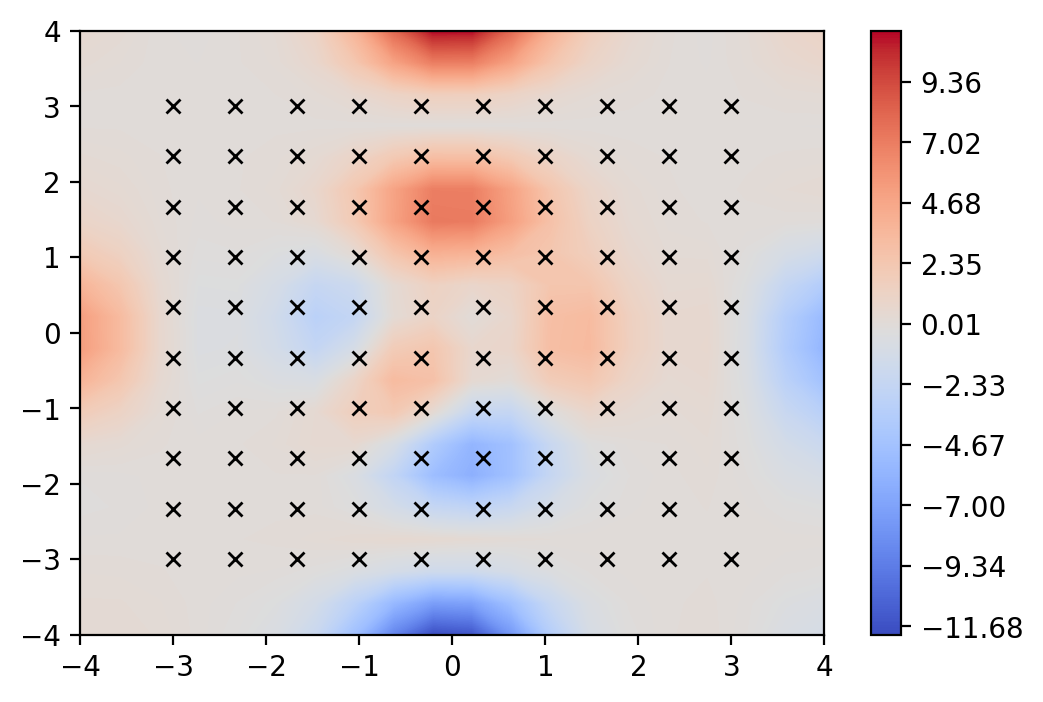

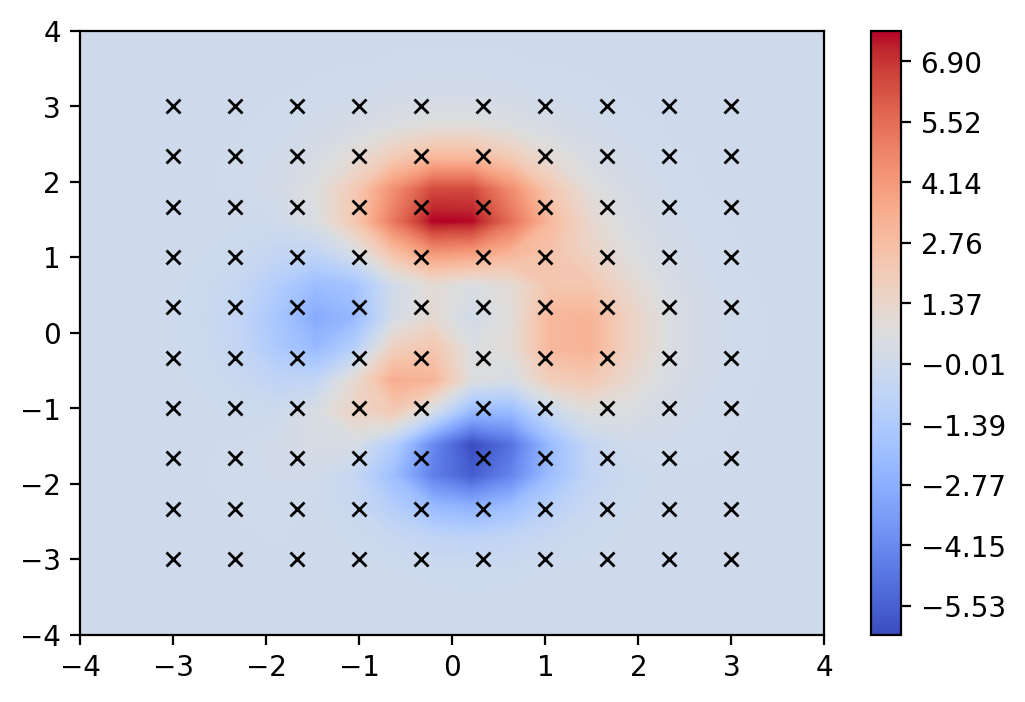

In [91]:
grid_shape = (y_pts, x_pts)
plot_function(pred_pts['x'], pred_pts['y'], gp_pred['mean'], grid_shape, train_pts=trains_pts)
plot_function(pred_pts['x'], pred_pts['y'], pred_pts['z'], grid_shape, train_pts=trains_pts)

Next, compare variance to difference between plots:

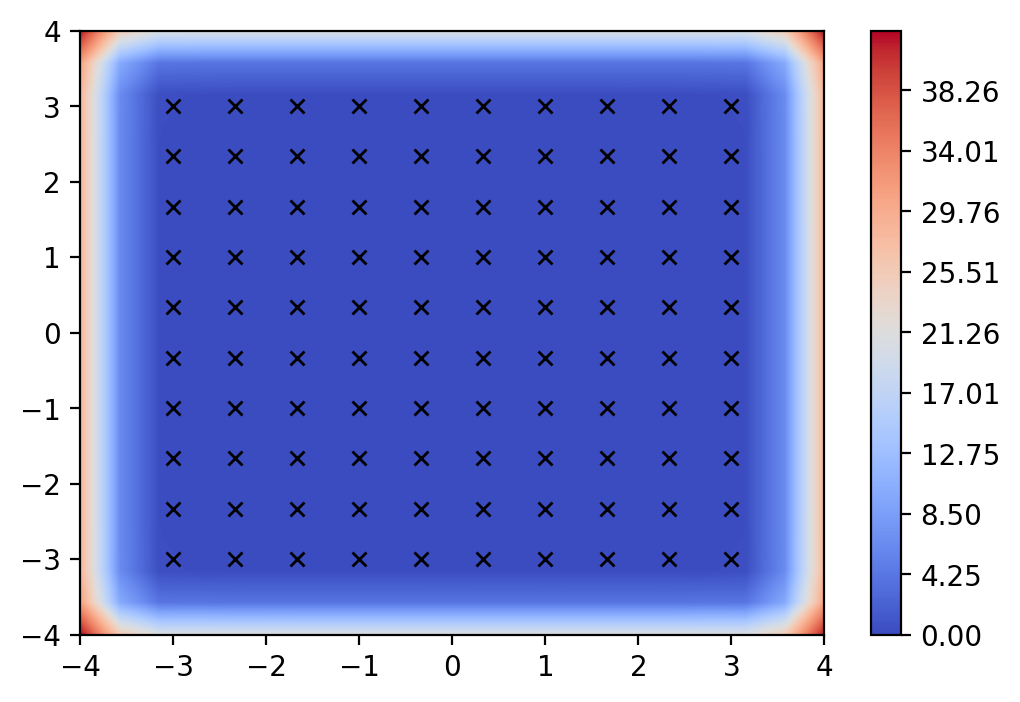

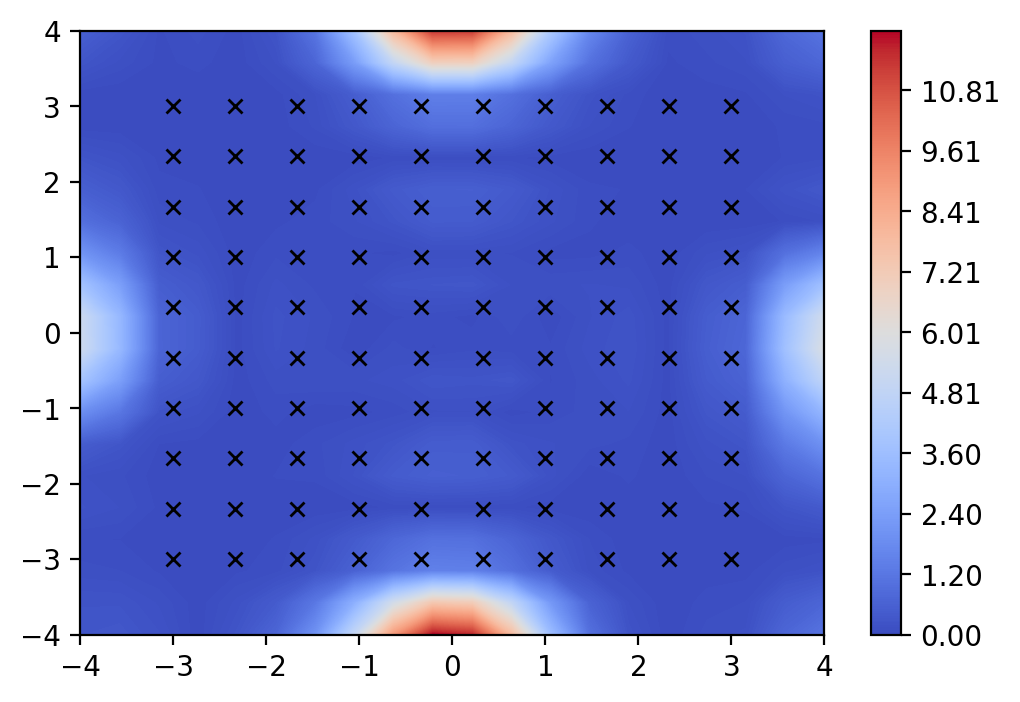

In [93]:
grid_shape = (y_pts, x_pts)
plot_function(pred_pts['x'], pred_pts['y'], gp_pred['var'], grid_shape, train_pts=trains_pts)
plot_function(pred_pts['x'], pred_pts['y'], jnp.abs(gp_pred['mean'] - pred_pts['z']), grid_shape, train_pts=trains_pts)

# Gradient Predictions

First, use GP to predict specified gradient:

In [95]:
# Create 'true' gradient function:
f_grad = jax.jacfwd(jax.jacfwd(f, argnums=0), argnums=1)
f_grad = jax.vmap(f_grad, in_axes=(0,0))

In [96]:
# Make predictions with GP:
x_lims = y_lims = [-4, 4]
x_pts = y_pts = 20
pred_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts, true_f=f_grad)
# Plot GP surrogate surface and original data surface:
grad = ({'idx': [0], 'order':1}, {'idx': [1], 'order':1})
gp_pred = gp.predict(pred_pts['input'], grad=grad)

Compare predictions to true result:

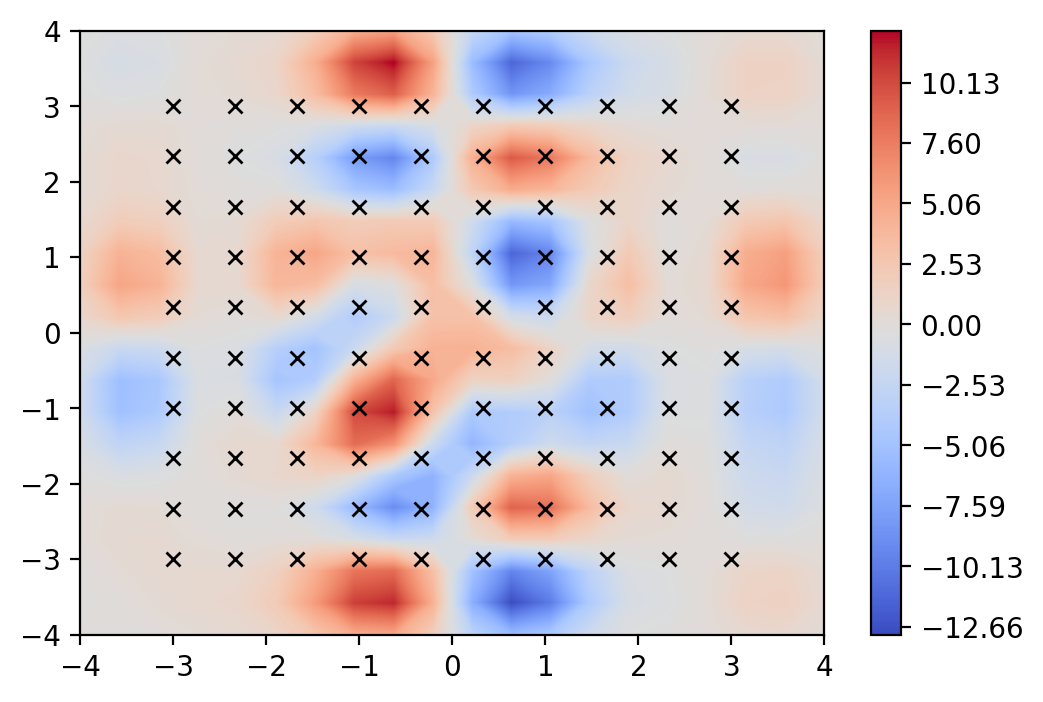

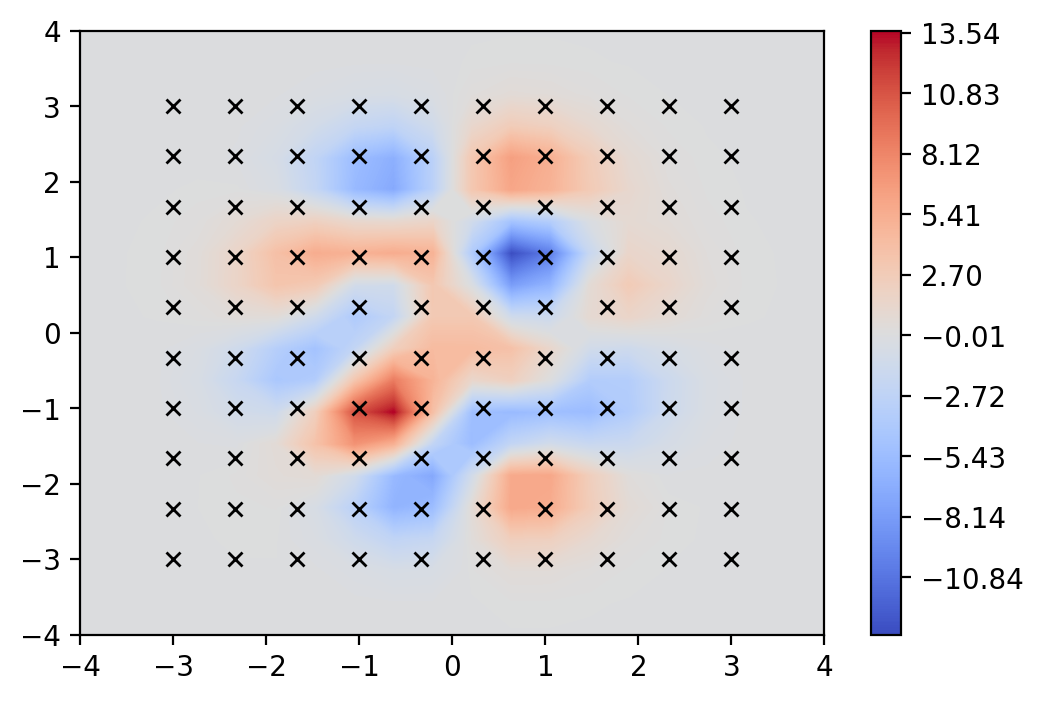

In [97]:
grid_shape = (y_pts, x_pts)
plot_function(pred_pts['x'], pred_pts['y'], gp_pred['mean'][:,0], grid_shape, train_pts=trains_pts)
plot_function(pred_pts['x'], pred_pts['y'], pred_pts['z'], grid_shape, train_pts=trains_pts)

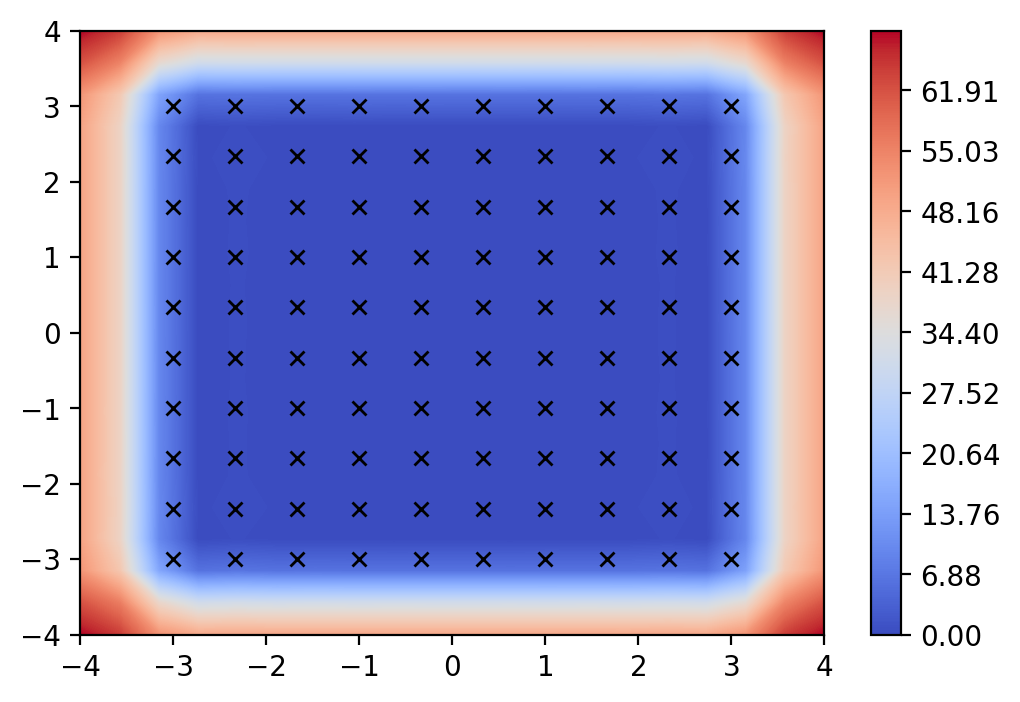

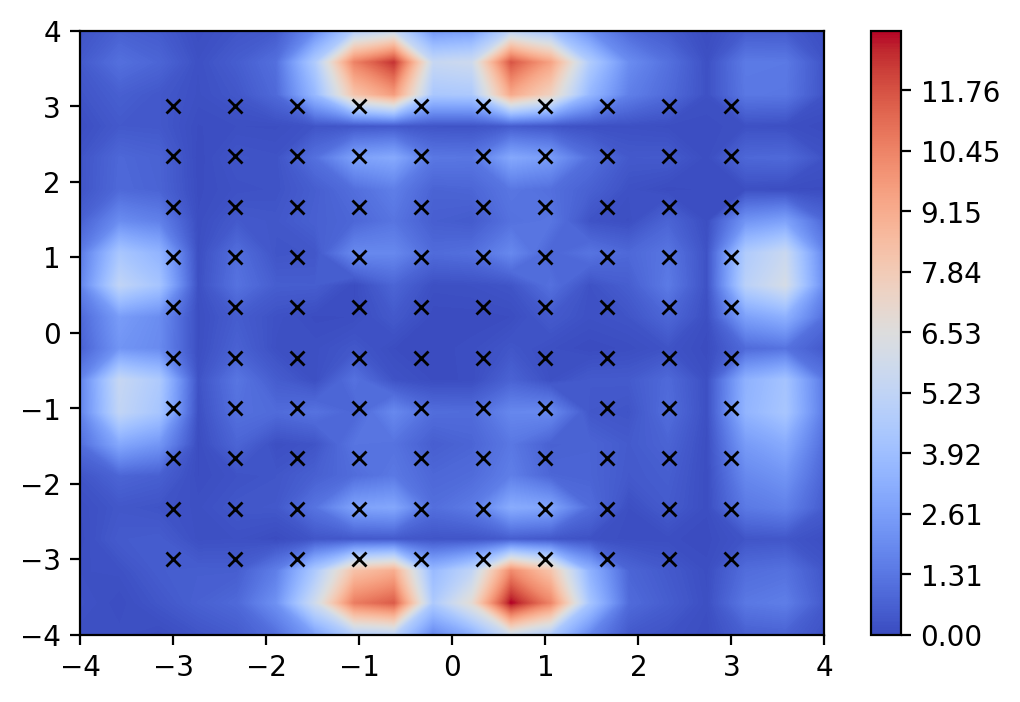

In [99]:
plot_function(pred_pts['x'], pred_pts['y'], gp_pred['var'], grid_shape, train_pts=trains_pts)
plot_function(pred_pts['x'], pred_pts['y'], jnp.abs(gp_pred['mean'].squeeze() - pred_pts['z'].squeeze()), grid_shape, train_pts=trains_pts)